# Assignment 5: Document Classification

**Gillian McGovern, Dhanya Nair, Dirk Hartog**

For this assignment, predict the class of new documents from documents that have already been classified (e.g. tagged), then analyze test documents to predict how they should be classified.

Dataset:

Corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam (https://archive.ics.uci.edu/dataset/94/spambase)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


#from scipy.stats import randint
#from sklearn.preprocessing import StandardScaler

# import libraries for obtaining metrics
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, classification_report, PredictionErrorDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import libraries to get images of tree
from sklearn import tree

## Data Key

48 continuous attributes for word types **word_freq_WORD**
- Frequency of the word = percentage of words in the e-mail that match WORD,
    - (number of times the WORD appears in the e-mail) / total number of words in e-mail * 100.

6 continuous real attributes of type **char_freq_CHAR**
- char_freq_CHAR = percentage of characters in the e-mail that match CHAR,
    - (number of CHAR occurences) / total characters in e-mail * 100

1 continuous attribute **capital_run_length_average**
- Average length of uninterrupted sequences of capital letters

1 continuous integer attribute of type **capital_run_length_longest**
- Length of longest uninterrupted sequence of capital letters

1 continuous integer attribute of type **capital_run_length_total**
- sum of length of uninterrupted sequences of capital letters
- total number of capital letters in the e-mail

1 nominal {0,1} class attribute of type spam **label**
- Denotes whether the e-mail was considered spam (1) or not (0)

## Load Data

In [ ]:
emails = pd.read_csv("https://raw.githubusercontent.com/D-hartog/DATA620/refs/heads/main/Assignment5/spambase.data", names = [i for i in range(0,58)])
emails.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [ ]:
import requests

url = 'https://raw.githubusercontent.com/D-hartog/DATA620/refs/heads/main/Assignment5/names.txt'  # Replace with the raw URL of your text file
response = requests.get(url)
text_content = response.text

text_content.split("\n")

names = []

for line in text_content.split("\n"):
  #print(line)
  col = re.findall(f'^word.*:|char.*:|capital.*:', line)
  #print(col)
  if col:
    names.append(col[0])

names = [name.rstrip(':') for name in names]

names.append("label")

emails.columns = names

In [ ]:
emails.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## EDA

In [ ]:
# No missing values
emails.isna().any().all()

np.False_

In [ ]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

There are 4,601 observations and 58 variables (57 features) for this dataset.

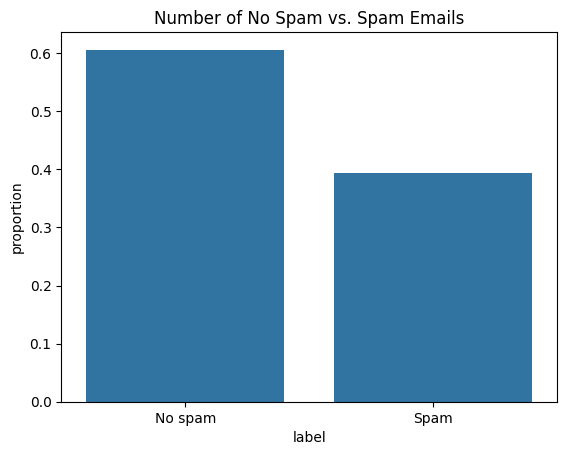

In [ ]:
# Plot the number of spam vs ham values

sns.countplot(data = emails, x = "label", stat = "proportion")
plt.xticks(ticks = [0,1], labels = ["No spam", "Spam"])
plt.title("Number of No Spam vs. Spam Emails")
plt.show()

The ratio of number of ham (no spam) emails to spam is 3:2 making this dataset unbalanced. We will have to address this later on before making the models.

In [ ]:
# Which features have the highest average frequency - first 48 attributes

word_descriptive_stats = emails[emails.columns[0:48]].describe().T.sort_values("mean", ascending = False)

word_descriptive_stats[0:10]

,count,mean,std,min,25%,50%,75%,max
word_freq_you,4601.0,1.662100,1.775481,0.0,0.0,1.31,2.64,18.75
word_freq_your,4601.0,0.809761,1.200810,0.0,0.0,0.22,1.27,11.11
word_freq_george,4601.0,0.767305,3.367292,0.0,0.0,0.00,0.00,33.33
word_freq_hp,4601.0,0.549504,1.671349,0.0,0.0,0.00,0.00,20.83
word_freq_will,4601.0,0.541702,0.861698,0.0,0.0,0.10,0.80,9.67
word_freq_our,4601.0,0.312223,0.672513,0.0,0.0,0.00,0.38,10.00
word_freq_re,4601.0,0.301224,1.011687,0.0,0.0,0.00,0.11,21.42
word_freq_all,4601.0,0.280656,0.504143,0.0,0.0,0.00,0.42,5.10
word_freq_hpl,4601.0,0.265384,0.886955,0.0,0.0,0.00,0.00,16.66
word_freq_free,4601.0,0.248848,0.825792,0.0,0.0,0.00,0.10,20.00


### Visualizations

Difference in features between Spam and No Spam. Comparing the frequencies between the target categories will give us an idea of what characters or words might be most important in identifying a spam email for this data set.

In [ ]:
# Visualize the average frequencies between no spam and spam
gbo_label = emails.groupby("label", as_index = False).agg("mean")
gbo_label

,label,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0,0.073479,0.244466,0.200581,0.000886,0.181040,0.044544,0.009383,0.038415,0.038049,...,0.051227,0.050281,0.158578,0.022684,0.109984,0.011648,0.021713,2.377301,18.214491,161.470947
1,1,0.152339,0.164650,0.403795,0.164672,0.513955,0.174876,0.275405,0.208141,0.170061,...,0.002101,0.020573,0.108970,0.008199,0.513713,0.174478,0.078877,9.519165,104.393271,470.619415


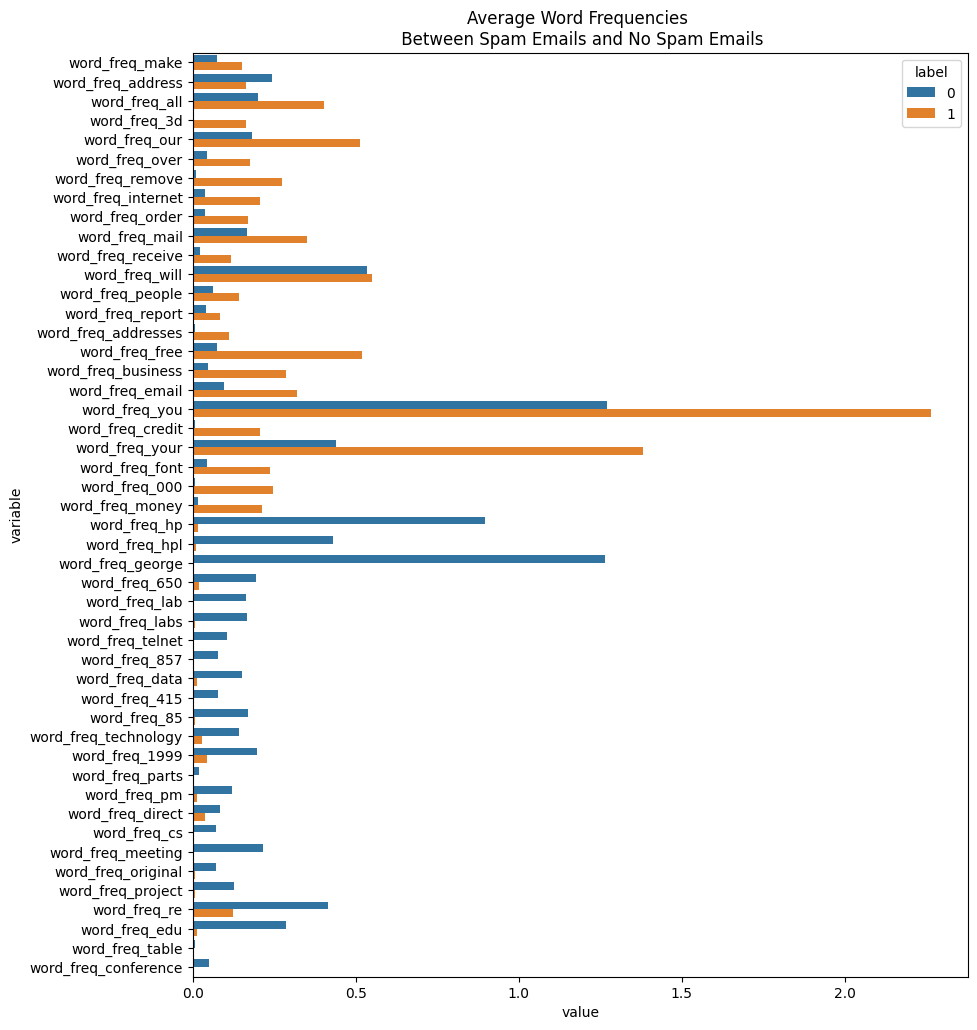

In [ ]:
# Plot Average Word Frequencies Between Spam Emails and No Spam Emails
plt.figure(figsize = (10, 12))
gbo_pivot = pd.melt(gbo_label[gbo_label.columns[0:49]], id_vars = "label")
sns.barplot(gbo_pivot, x = "value", y = "variable", hue = "label")
#plt.xticks(ticks = [0,1], labels = ["No spam", "Spam"])
plt.title("Average Word Frequencies \n Between Spam Emails and No Spam Emails")
plt.show()

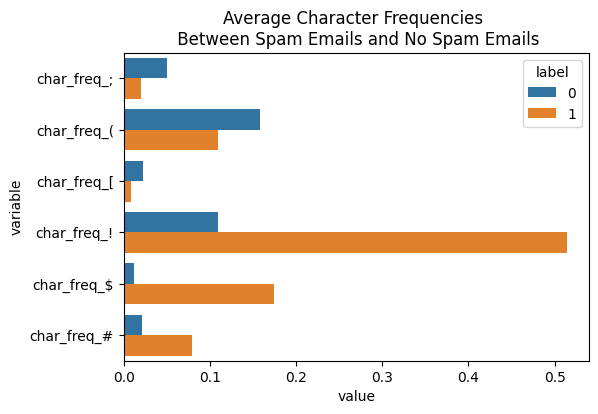

In [ ]:
# Plot Average Character Frequencies Between Spam Emails and No Spam Emails
plt.figure(figsize = (6, 4))
char_cols = [col for col in gbo_label.columns if col.startswith("char")]
char_cols.append("label")

gbo_pivot = pd.melt(gbo_label[char_cols], id_vars = "label")
sns.barplot(gbo_pivot, x = "value", y = "variable", hue = "label")
#plt.xticks(ticks = [0,1], labels = ["No spam", "Spam"])
plt.title("Average Character Frequencies \n Between Spam Emails and No Spam Emails")
plt.show()

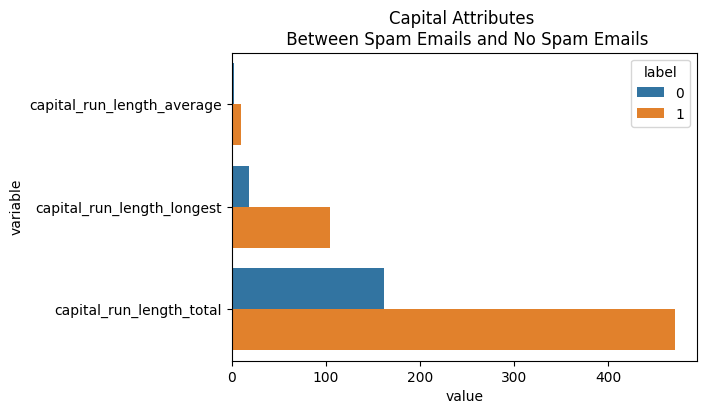

In [ ]:
# Plot Capital Attributes Between Spam Emails and No Spam Emails
plt.figure(figsize = (6, 4))
char_cols = [col for col in gbo_label.columns if col.startswith("capital")]
char_cols.append("label")

gbo_pivot = pd.melt(gbo_label[char_cols], id_vars = "label")
sns.barplot(gbo_pivot, x = "value", y = "variable", hue = "label")
#plt.xticks(ticks = [0,1], labels = ["No spam", "Spam"])
plt.title("Capital Attributes \n Between Spam Emails and No Spam Emails")
plt.show()

These visualizations show us which features heavily indicate if an email is spam or not.

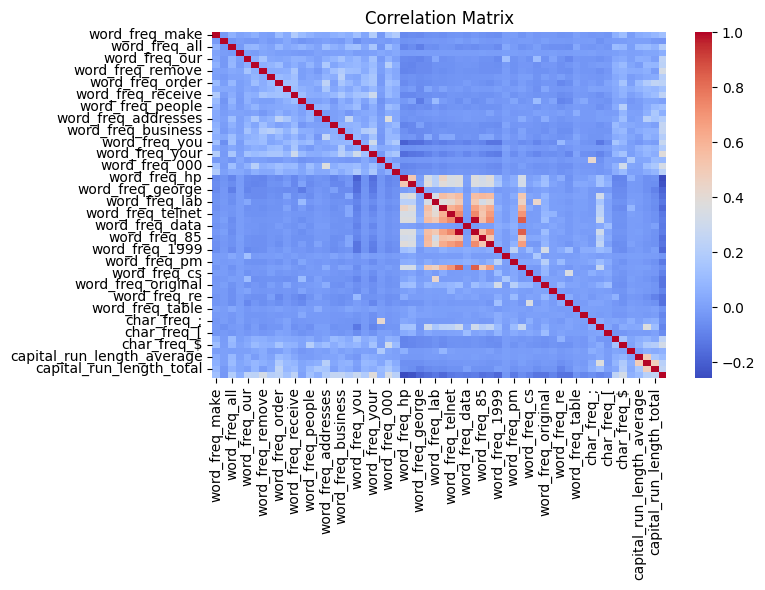

In [ ]:
# Check for multicollinearity
correlation_emails = emails.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_emails, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Most columns are not highly correlated.

### Create training and test data

In [ ]:
# Try splitting data first and then applying SMOTE to just the training data for the models, evaluate with the real test data

# Split data into a training and testing set

X = emails.drop(["label"], axis=1)
y = emails["label"]

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size= 0.3,
                                                    random_state = 123,
                                                    stratify=y)

### Balance the target variable

There is an imbalance in the target variable which may introduce bias the classification models. The method below called SMOTE Synthetic Minority Over-Sampling Technique (SMOTE). SMOTE generates samples of minority classes to make the class distribution balanced.

In [ ]:
# SMOTE

x = emails.drop(["label"],axis=1)
y = emails["label"]

from imblearn.over_sampling import SMOTE

# Set sampling_strategy to "minority" to resample only the minority class
smote=SMOTE(sampling_strategy='minority', random_state=123)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training data count:")
display(y_train.value_counts())
print("\nSMOTE resampled training data count:")
display(y_train_resampled.value_counts())

training_balanced_email_data = X_train_resampled.copy()
training_balanced_email_data['label'] = y_train_resampled

Original training data count:


,count
label,
0,1951
1,1269



SMOTE resampled training data count:


,count
label,
1,1951
0,1951


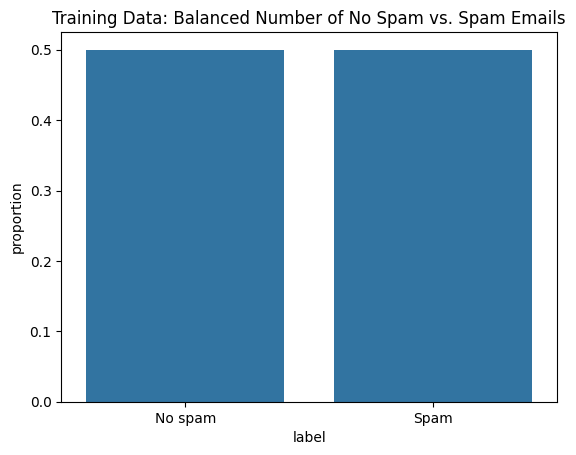

In [ ]:
# Re-Plot the number of spam vs ham values

sns.countplot(data = training_balanced_email_data, x = "label", stat = "proportion")
plt.xticks(ticks = [0,1], labels = ["No spam", "Spam"])
plt.title("Training Data: Balanced Number of No Spam vs. Spam Emails")
plt.show()

Our training data is now balanced which will greatly help the models create non-biased and reliable predictions.

## Build classification models

### Logistice Regression

In [ ]:
# Create a logistic regression object
logreg = LogisticRegression(solver = 'liblinear', max_iter = 1000,random_state=123)

# Fit the classifier to the training data
model = logreg.fit(X_train_resampled, y_train_resampled)

# Predict values
y_pred = model.predict(X_test)

predict_probs = model.predict_proba(X_test)

In [ ]:
# Create a data frame to visualize the actual and predicted values and the probabilities of the predicted values

predict_probs_df = pd.DataFrame(predict_probs, columns=logreg.classes_)
outcome_class = pd.DataFrame({"Actual Values" : y_test, "Predicted Values" : y_pred})

# Add the index as it denotes which email from the split is in the test set
outcome_class.insert(loc = 0, column = "emial_index", value = outcome_class.index)

outcome_class.reset_index(inplace = True, drop = True)

# Merge the outcome class and probabilities
result_df = pd.merge(outcome_class, predict_probs_df, left_index = True, right_index = True)

# Show only incorrect predictions:
result_df[result_df["Actual Values"] != result_df["Predicted Values"]].head()

,emial_index,Actual Values,Predicted Values,0,1
13,113,1,0,0.609060,0.390940
41,3760,0,1,0.012049,0.987951
62,4387,0,1,0.112353,0.887647
64,321,1,0,0.653959,0.346041
69,2293,0,1,0.358493,0.641507


In [ ]:
# Show the SPAM misclassifications

print("SPAM misclassifications: ")
result_df[(result_df["Actual Values"] == 1) &
 (result_df["Actual Values"] != result_df["Predicted Values"])].shape

(48, 5)

In [ ]:
# Show the NO SPAM misclassifications

print("HAM misclassifications: ")
result_df[(result_df["Actual Values"] == 0) &
 (result_df["Actual Values"] != result_df["Predicted Values"])].shape

(48, 5)

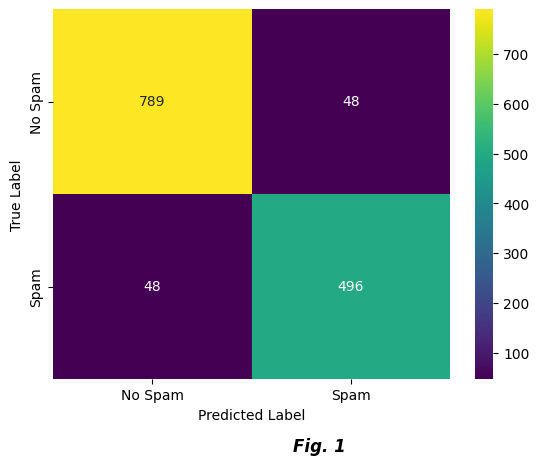

In [ ]:
# Confusion Matrix

con_mat = confusion_matrix(y_true = y_test,
                           y_pred = y_pred, labels = model.classes_)

sns.heatmap(con_mat, annot=True,
           xticklabels = ["No Spam", "Spam"],
           yticklabels = ["No Spam", "Spam"],
           fmt="d",
           cmap="viridis")

# Set labels so they are not in exponential form
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.figtext(x = 0.5, y = -0.04, s = "Fig. 1",
            fontstyle = "italic",
            fontweight = "demibold",
            fontsize = 12)
plt.show()

In [ ]:
# F1 Score

print("F1 score: ", f1_score(y_test, y_pred))

# Sensitivity - True Positive Rate - (TP/TP + FN)
# How many TP the model labeled incorrectly
print("Recall score: ", recall_score(y_test, y_pred))

# Precision -  Accuracy of predicting a predicted postive outcome (TP / TP + FP)
# How many Predicted positives were wrong
print("Precision score: ", precision_score(y_test, y_pred))

# Specificity - The proportion of negative classes that were correctly classified as negative (TN / TN + FP)
print("Specificity score: ", con_mat[0,0]/(con_mat[0,0] + con_mat[0,1]))

# Accuracy - The percent or proportion of cases classified corectly
print("Accuracy score: ", accuracy_score(y_test, y_pred))

F1 score:  0.9117647058823529
Recall score:  0.9117647058823529
Precision score:  0.9117647058823529
Specificity score:  0.942652329749104
Accuracy score:  0.9304851556842868


0.9746885761473049


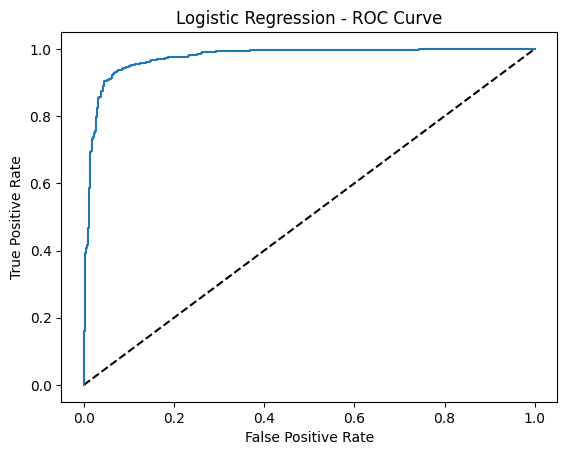

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

print(roc_auc_score(y_test, predict_probs[:,1]))

# fpr = false positive rate
# tpr = true positive rate
# thresholds

fpr, tpr, thresholds, = roc_curve(y_test, predict_probs[:,1])
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.show()

#### Hyperparameter Tuning

In [ ]:
# Using roc-auc as scoring criteria to evaluate the model across all classification thresholds.

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': np.logspace(-3, 3, 7), # Inverse of regularization strength - Smaller values specify stronger regularization
    'penalty': ['l1', 'l2'], # Norm of the penalty
    'solver': ['liblinear']  # Algorithm to use in the optimization problem. Default is ‘lbfgs’. liblinear supports both l1 and l2 and is best for smaller datasets
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000),
                           param_grid,
                           cv=5,
                           scoring='roc_auc',
                           verbose=1)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best AUC on CV:", grid_search.best_score_)



Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best parameters: {'C': np.float64(1.0), 'penalty': 'l1', 'solver': 'liblinear'}
Best AUC on CV: 0.974247454646038


In [ ]:
# If high Recall is a priority to ensure model detects spam
# Set up parameters
param_grid = {
  "solver" : ['newton-cg', 'lbfgs', 'liblinear'],
  "penalty" : ['l2'],
  "C" : [100, 10, 1.0, 0.1, 0.01]
}

# Create model
lr_model = LogisticRegression(max_iter = 1000)

# Find the best params via GridSearchCV using recall as the metric
CV_lr_model = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_lr_model.fit(X_train_resampled, y_train_resampled)

print('Best params for Logistic Regression Classifier:')
print(CV_lr_model.best_params_)

Best params for Logistic Regression Classifier:
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
mean_scores = CV_lr_model.cv_results_["mean_test_score"]

c = []
p = []
s = []

for d in CV_lr_model.cv_results_["params"]:
  c.append(d["C"])
  p.append(d["penalty"])
  s.append(d["solver"])

CV_lr_model_df = pd.DataFrame({"C" : c,
              "penalty" : p,
              "solver" : s,
              "mean_score" : mean_scores})

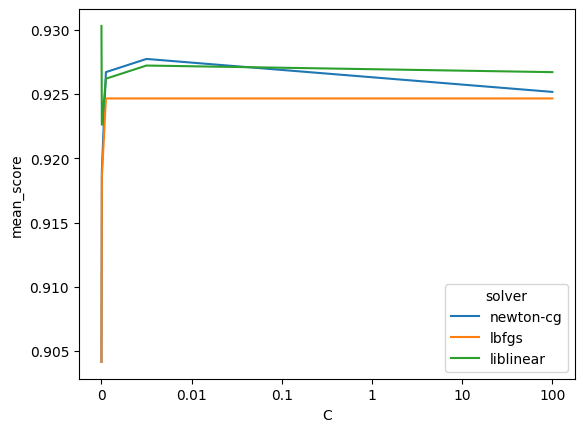

In [ ]:
# Visualize tuning
sns.lineplot(CV_lr_model_df, x = "C", y = "mean_score", hue = "solver")
plt.xticks(ticks = [0,20,40,60,80,100], labels = [0, 0.01, 0.1, 1, 10, 100])
plt.show()

Most solvers basically flatten out as C increases, which makes sense as 0.01 is the best C value.

#### Predictions Using Best Model

In [ ]:
# Create a logistic regression object with the best parameters
logreg2 = LogisticRegression(solver = 'liblinear', C = 0.1, penalty = "l2", max_iter = 1000)

#if ROC-AUC is the scoring criteria for evaluating the model across all classification thresholds.
#logreg2 = LogisticRegression(solver = 'liblinear', C = 1.0, penalty = "l1", max_iter = 1000)

# Fit the classifier to the training data
lr_model2 = logreg2.fit(X_train_resampled, y_train_resampled)

# Predict values
y_pred = lr_model2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       837
           1       0.91      0.92      0.91       544

    accuracy                           0.93      1381
   macro avg       0.93      0.93      0.93      1381
weighted avg       0.93      0.93      0.93      1381



The model performs very well overall with accuracy of 93%, Recall of 91.2% and Precision  of 91.2%. The ROC AUC of 0.974 indicates the model has an excellent ability to separate spam from ham.

### Random Forest

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       837
           1       0.94      0.94      0.94       544

    accuracy                           0.95      1381
   macro avg       0.95      0.95      0.95      1381
weighted avg       0.95      0.95      0.95      1381

Confusion Matrix:
 [[804  33]
 [ 35 509]]


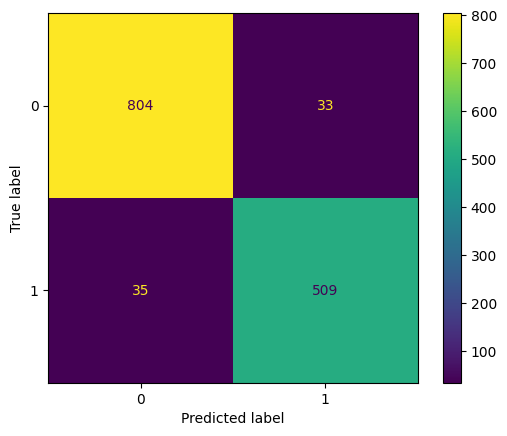

In [ ]:
# Random Forest Model Without Hypertuning

# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=123)

# Fit model to training data
model.fit(X_train_resampled, y_train_resampled)

# Grab the predicted values and probabilities from the model
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
# print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

#### Hyperparameter Tuning

In [ ]:
# Set up parameters
param_grid = {
    'n_estimators': [100, 200], # The number of trees in the forest (default is 100)
    'max_depth': [None, 10, 20], # The maximum depth of the tree (default is None)
    'min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node. For classification with few classes, min_samples_leaf=1 is often the best choice.
    'min_samples_split': [2, 5] # The minimum number of samples required to split an internal node
}

# Create model
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=123)

# Find the best params via GridSearchCV using recall as the metric
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train_resampled, y_train_resampled)
print('Best params for Random Forest Classifier:')
print(CV_model.best_params_)

means = CV_model.cv_results_['mean_test_score']
params = CV_model.cv_results_['params']

Best params for Random Forest Classifier:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Store the model results for visualization in the next cell
min_samples_leafs = []
n_estimators = []
min_samples_splits = []
max_depths = []

for mean, param in zip(means, params):
    min_samples_leafs.append(param['min_samples_leaf'])
    n_estimators.append(param['n_estimators'])
    min_samples_splits.append(param['min_samples_split'])
    max_depths.append(param['max_depth'])

rf_results = {
    'mean_test_score': means,
    'min_samples_leaf':min_samples_leafs,
    'n_estimators': n_estimators,
    'min_samples_splits': min_samples_splits,
    'max_depths': max_depths
}

rf_results_df = pd.DataFrame(rf_results)

# Pick 'n_estimators' and 'min_samples_splits to visualize for now
rf_results_df_grouped = rf_results_df.groupby(['n_estimators', 'min_samples_splits']).agg(
    avg_score=('mean_test_score', 'mean')
).reset_index()

rf_results_df_grouped_pivot = rf_results_df_grouped.pivot(index='n_estimators', columns='min_samples_splits', values='avg_score')

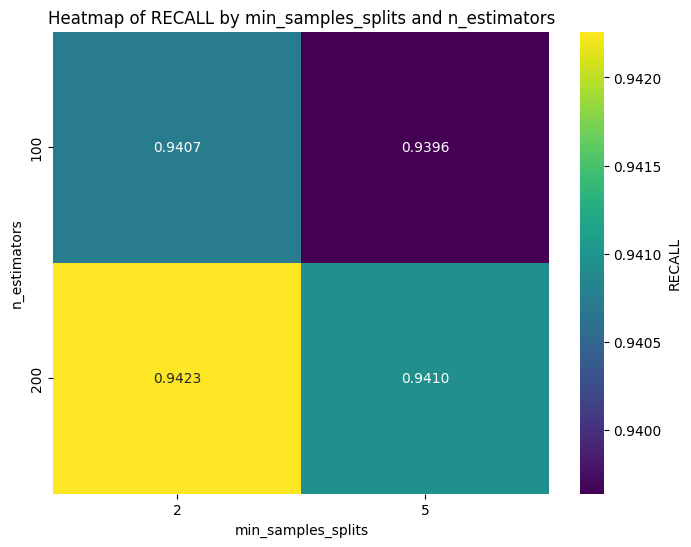

In [ ]:
# Visualize Tuning

# min_samples_splits vs n_estimators
plt.figure(figsize=(8, 6))
sns.heatmap(rf_results_df_grouped_pivot, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'RECALL'})
plt.title('Heatmap of RECALL by min_samples_splits and n_estimators')
plt.xlabel('min_samples_splits')
plt.ylabel('n_estimators')
plt.show()

We can see here how the best recall is produced by a lower `min_samples_splits` and a higher `n_estimators`. Although, all of these recall values are very close.

#### Predictions Using Best Model

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       837
           1       0.94      0.94      0.94       544

    accuracy                           0.95      1381
   macro avg       0.95      0.95      0.95      1381
weighted avg       0.95      0.95      0.95      1381

Confusion Matrix:
 [[804  33]
 [ 35 509]]


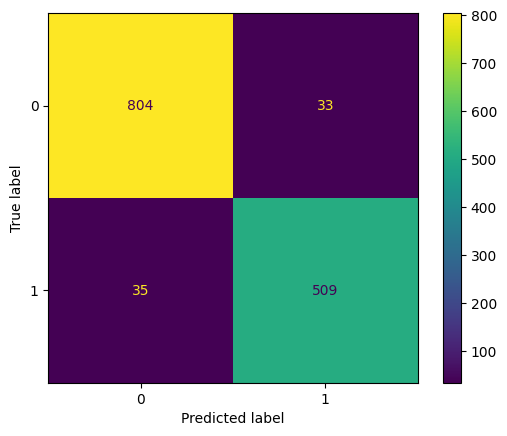

In [ ]:
# Set up models with best params
model = RandomForestClassifier(class_weight='balanced_subsample', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=123)

# Fit model to training data
model.fit(X_train_resampled, y_train_resampled)

# Grab the predicted values and probabilities from the model
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
# print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

The model performs significantly well overall with accuracy of 95%, Recall of 94% and Precision of 94% and ROC AUC of 0.986. This is slightly better than the logistic regression classifier.

0.9864548193829503


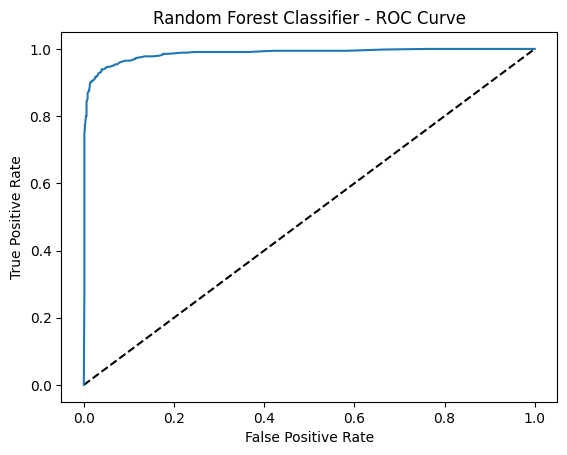

In [ ]:
# ROC Curve
# fpr = false positive rate
# tpr = true positive rate
# thresholds

print(roc_auc_score(y_test, probs[:,1]))

fpr, tpr, thresholds, = roc_curve(y_test, probs[:,1])
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier - ROC Curve')
plt.show()

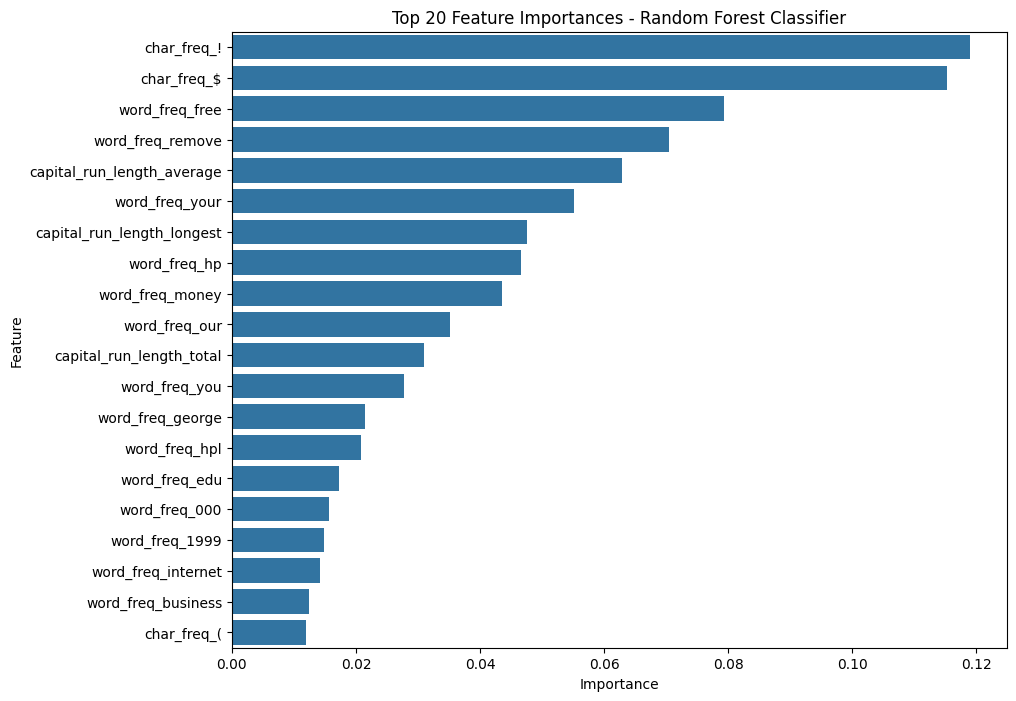

In [ ]:
# The feature importance of the random classifier model

feature_importances = model.feature_importances_
features = X_train_resampled.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20)) # Display top 20
plt.title('Top 20 Feature Importances - Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


The most important features are `char_freq_!`, `char_freq_$`, `word_freq_free`, `word_freq_remove` and `capital_run_length_average`. Interestingly, punctuation is the most important feature for determining spam. If there are many `!`s, it most likely means the email is trying to overly entice the receiver into taking some sort of action, such as promising some crazy unbelievable deal. `$` and `free` also strongly relate to the idea of enticing people about money or a great bargain.



**Summary**
1.  **Data Preparation:**
    *   Checked for missing values (none found).
    *   Visualizing the class distribution of spam vs. non-spam emails using a count plot, revealing an imbalance (more non-spam than spam).

2.  **Feature Analysis and Visualization:**
    *   Dataset shape: (4601, 58)
    *  Feature Groups: word_features: 48 features, char_features: 6 features and capital_features: 3 features
    *  Visual statistics for the word frequency features showed word_freq_you , word_freq_your, word_freq_will and word_freq_our used most in spam emails.
    *   Visualizing the average frequencies of character features, and capital letter features revealed char_freq_! , $ and # higher in spam emails and capital run is longest in spam emails.
    *   A correlation heatmap did not show multicollinearity between features.

3.  **Data Splitting and Balancing:**
    *   The data is split into training and testing sets with a 70/30 ratio and stratification to maintain the original class distribution in the splits.
    *   Recognizing the class imbalance, the Synthetic Minority Over-sampling Technique (SMOTE) is applied*only to the training data.
    *   The class distribution of the resampled training data is then visualized to confirm the balancing.

4.  **Model Building and Evaluation (Logistic Regression):**
    *   A Logistic Regression model is initialized and predictions are made on the test data.
    *   Evaluation metrics are calculated and displayed. The model performs very well overall with accuracy of 93%, Recall of 91.2% and Precision  of 91.2%.  The ROC AUC of 0.974 indicates the model has an excellent ability to separate spam from ham.
    *   Hyperparameter Tuning:
        *   False negatives (43 spam emails predicted as non-spam) are more concerning in spam detection  and worth minimizing.
Hence for security-focused email filters, we prioritized high recall (catch more spam).
        *   The best parameters found are C=0.1 , solver = liblinear and penalty = l2.
        *   The impact of the `C` hyperparameter on the mean test recall score is visualized for different solvers.
    *   A second Logistic Regression model is trained with the best hyperparameters found and evaluated again using `classification_report`.There was no difference in the evaluations metrics.

5.  **Model Building and Evaluation (Random Forest):**
    *   A Random Forest Classifier is initialized and trained.
    *   Evaluation metrics are calculated and displayed. The model performs significantly well overall with accuracy of 95%, Recall of 94% and Precision  of 94% and ROC AUC of 0.986.
    *   Hyperparameter Tuning:
        *   The best hyperparameters (`n_estimators` = 200, `max_depth`= none, `min_samples_leaf` = 1, `min_samples_split`= 2) were found for the Random Forest model based on the `recall` scoring metric.
        *   A heatmap is used to visualize the mean test recall score across combinations of `min_samples_splits` and `n_estimators`.
    *   A second Random Forest model is trained with the best hyperparameters found and evaluated again using `classification_report`. There was no difference in the evaluations metrics.

Overall Random Forest classification provided better evaluation metric and hence is the suitable model for Spam detection.

The most important features are char_freq_!, char_freq_$ , word_freq_free, word_freq_remove and capital_run_length_average.

Some other models to look into in the future would be Support Vector Classification, Xgboost classification, and Naive Bayes classification.
